# FAKE NEWS DETECTION USING DEEP LEARNING

## 1. Preparation

### 1.1. Download Data

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
import pandas as pd
import numpy as np
import nltk
import string
from gensim.models import Word2Vec
from gensim.models import FastText
from nltk.corpus import stopwords as sw
from nltk.corpus import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from itertools import chain
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(sw.words('english')) 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(sw.words('english')) 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1MagOVnkudsYsCtz9-U6-mWBOcydPCe0s'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('BuzzFeed_fake_news_content.csv')

id = '1LA6oUXDxsux_CSsClQQdVG6Awnx5NvTW'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('BuzzFeed_real_news_content.csv')

id = '1PH22HewU7HYhaw6ZjD503q4blq-ekbwf'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PF_fake.csv')

id = '1FPL-p7z5NgoiblJ3_YEQIqy0uZwh_wYK'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('PolitiFact_real_news_content.csv')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. Dataset and Parameters Setting

In [0]:
# 0=BuzzFeed 1=PolitiFact 2=Both
dataset=1
# Embedding_size
embedding_size=128
# Doc Vector size
d2v_size=32
# LDA number of topics
lda_topic=6
# 0=text+title 1=lda2vec 3=all
emb_type=3
pretrain=0

In [0]:
# BuzzFeed and Politifact DATASET
BF_fake = pd.read_csv('BuzzFeed_fake_news_content.csv')
BF_real = pd.read_csv('BuzzFeed_real_news_content.csv')
PF_fake = pd.read_csv('PF_fake.csv')
PF_real = pd.read_csv('PolitiFact_real_news_content.csv')
BF_fake = BF_fake.drop([4,9,32])
BF_real = BF_real.drop([38])
PF_fake = PF_fake.drop([37,62])
PF_fake = PF_fake.drop([7,23,42,51,88])

# Switch of dataset selection
if dataset==0:
  BF = pd.concat([BF_fake ,BF_real])
  numFake = BF_fake.shape[0]
elif dataset==1:
  BF = pd.concat([PF_fake ,PF_real])
  numFake = PF_fake.shape[0]
  
# Combination of two dataset
else:
  BF = pd.concat([PF_fake,BF_fake,PF_real,BF_real])
  numFake = PF_fake.shape[0]+BF_fake.shape[0]


In [0]:
PF_fake.head()

,text,title
0,335 SHARES SHARE THIS STORY\n\nRepublican atta...,Virginia Republican Wants Schools To Check Chi...
1,BREAKING!\n\nLiberal rag Huffington Post is re...,PUTIN INTERFERENCE COULD GIVE COURTS LEGAL RIG...
2,Three women who all went missing in the mid-19...,Barrels Removed From Clinton Property Containe...
3,"On Monday, Bumble Bee Foods and 2 employees we...",Massive Bumble Bee Recall After 2 Employees Ad...
4,"Republican Rep. Trey Gowdy, who sits on the Ho...",JUST IN TODAY Trey Gowdy Is The NEW DIRECTOR O...


In [0]:
text_sentence=col_one_list = BF['text'].tolist()
title_sentence=col_one_list = BF['title'].tolist()
both_sentence=[]
for i in range(len(text_sentence)):
  both_sentence.append(title_sentence[i]+' '+'EndOfTitle'+' '+text_sentence[i])
sentences=both_sentence

### 1.3. Word Embedding

In [0]:
tokenizer=RegexpTokenizer(r'[a-zA-Z]{3,}')

tokenized_train=[]
i=0
for sentence in sentences:
  try:
    tokenized_train.append(tokenizer.tokenize(sentence))
  except:
    print(i)
    tokenized_train.append([])
  i+=1

filtered_train=[]
for i in range(len(tokenized_train)):
  filtered_train.append([])
  for w in tokenized_train[i]:
    if w.lower() not in stop_words: 
      filtered_train[i].append(w.lower()) 

lemmatzer=WordNetLemmatizer()

lemm_train=[]
for i in range(len(filtered_train)):
  lemm_train.append([])
  for w in filtered_train[i]:
    lemm_train[i].append(lemmatzer.lemmatize(w))

stemmer=PorterStemmer()
stem_train=[]
for i in range(len(filtered_train)):
  stem_train.append([])
  for w in filtered_train[i]:
    stem_train[i].append(stemmer.stem(w))

In [0]:
# join each sentences to one list
word_sequence = list(chain(*lemm_train))
# get unique words
word_list = list(chain(*lemm_train))
word_list = list(set(word_list))
word_list.sort()

# make dictionary so that we can be reference each index of unique word
word2ind = {w: i for i, w in enumerate(word_list)}


In [0]:
emb_size=embedding_size
w2v = Word2Vec(lemm_train, size=emb_size,iter=50, window=5, min_count=1, workers=4, sg=1)
embedding=np.array([w2v[i] for i in word_list])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


### 1.4. Document Embedding



In [0]:
import numpy as np
from tqdm import tqdm
import spacy
from gensim import corpora, models
from collections import Counter
nlp = spacy.load('en')
from collections import Counter
from tqdm import tqdm
# store an index with a document
docs = [(i, doc) for i, doc in enumerate(sentences)]
docs[40]

(40,
 'Trump Caught INVESTING in Dakota Pipeline Before Signing It EndOfTitle CNBC reported that Trump has substantial investments in the companies involved with the construction of the pipeline. Trump’s early decision to approve the pipeline was a conflict-of-interest, and we must impeach him for it.\n\nDonald Trump’s business investments spread throughout the world. Now, we know that he has ties to the Dakota Access Pipeline, the one that crosses sacred Indian land.\n\nThe construction of the pipeline raised the ire of Native American Sioux settlements in the area. It will cross sacred land and pollute their water supply.\n\nThe pipeline is also a threat to the Missouri and Mississippi Rivers, which provide drinking water for millions of people. In addition, the two rivers provide shipping avenues for commerce through the middle of the country.\n\nOpposition to the pipeline resulted in massive protests. The protests received international coverage when police and security workers for

In [0]:
########### Preprocess.py (from lda of TropComplique) ###########

def preprocess(docs, nlp, min_length, min_counts, max_counts):
    """Tokenize, clean, and encode documents.
    Arguments:
        docs: A list of tuples (index, string), each string is a document.
        nlp: A spaCy object, like nlp = spacy.load('en').
        min_length: An integer, minimum document length.
        min_counts: An integer, minimum count of a word.
        max_counts: An integer, maximum count of a word.
    Returns:
        encoded_docs: A list of tuples (index, list), each list is a document
            with words encoded by integer values.
        decoder: A dict, integer -> word.
        word_counts: A list of integers, counts of words that are in decoder.
            word_counts[i] is the number of occurrences of word decoder[i]
            in all documents in docs.
    """

    default = ["trump", "donald", "hillary", "clinton", "barack", "obama", 
               "say", "people", "president"]
               
    def clean_and_tokenize(doc):
        # remove excessive spaces
        text = ' '.join(doc.split())
        text = nlp(text)
        text = [t.lemma_ for t in text if t.is_alpha and len(t) > 2 and not t.is_stop]
        text = [t.lower() for t in text]
        text = [t for t in text if t not in default]

        return text

    tokenized_docs = [(i, clean_and_tokenize(doc)) for i, doc in tqdm(docs)]

    # remove short documents
    n_short_docs = sum(1 for i, doc in tokenized_docs if len(doc) < min_length)
    for i, doc in tokenized_docs:
      if len(doc) < min_length:
        print('remove index:', i)
    tokenized_docs = [(i, doc) for i, doc in tokenized_docs if len(doc) >= min_length]
    print(tokenized_docs.index)
    print('number of removed short documents:', n_short_docs)

    # remove some tokens
    counts = _count_unique_tokens(tokenized_docs)
    tokenized_docs = _remove_tokens(tokenized_docs, counts, min_counts, max_counts)
    for i, doc in tokenized_docs:
      if len(doc) < min_length:
        print('remove index:', i)
    n_short_docs = sum(1 for i, doc in tokenized_docs if len(doc) < min_length)
    tokenized_docs = [(i, doc) for i, doc in tokenized_docs if len(doc) >= min_length]
    print('number of additionally removed short documents:', n_short_docs)

    counts = _count_unique_tokens(tokenized_docs)
    encoder, decoder, word_counts = _create_token_encoder(counts)
    
    print('\nminimum word count number:', word_counts[-1])
    print('this number can be less than MIN_COUNTS because of document removal')

    encoded_docs = _encode(tokenized_docs, encoder)
    return encoded_docs, decoder, word_counts


def _count_unique_tokens(tokenized_docs):
    tokens = []
    for i, doc in tokenized_docs:
        tokens += doc
    return Counter(tokens)


def _encode(tokenized_docs, encoder):
    return [(i, [encoder[t] for t in doc]) for i, doc in tokenized_docs]


def _remove_tokens(tokenized_docs, counts, min_counts, max_counts):
    """
    Words with count < min_counts or count > max_counts
    will be removed.
    """
    total_tokens_count = sum(
        count for token, count in counts.most_common()
    )
    print('total number of tokens:', total_tokens_count)

    unknown_tokens_count = sum(
        count for token, count in counts.most_common()
        if count < min_counts or count > max_counts
    )
    print('number of tokens to be removed:', unknown_tokens_count)

    keep = {}
    for token, count in counts.most_common():
        keep[token] = count >= min_counts and count <= max_counts

    return [(i, [t for t in doc if keep[t]]) for i, doc in tokenized_docs]


def _create_token_encoder(counts):

    total_tokens_count = sum(
        count for token, count in counts.most_common()
    )
    print('total number of tokens:', total_tokens_count)

    encoder = {}
    decoder = {}
    word_counts = []
    i = 0

    for token, count in counts.most_common():
        # counts.most_common() is in decreasing count order
        encoder[token] = i
        decoder[i] = token
        word_counts.append(count)
        i += 1

    return encoder, decoder, word_counts

In [0]:
MIN_COUNTS = 15
MAX_COUNTS = 150
# words with count < MIN_COUNTS
# and count > MAX_COUNTS
# will be removed

MIN_LENGTH = 15
# minimum document length 
# (number of words)
# after preprocessing

# half the size of the context around a word
HALF_WINDOW_SIZE = 5
# it must be that 2*HALF_WINDOW_SIZE < MIN_LENGTH

In [0]:
encoded_docs, decoder, word_counts = preprocess( 
    docs, nlp, MIN_LENGTH, MIN_COUNTS, MAX_COUNTS)

100%|██████████| 233/233 [00:23<00:00,  9.71it/s]

<built-in method index of list object at 0x7f31bfcaf988>
number of removed short documents: 0
total number of tokens: 58348
number of tokens to be removed: 26700
number of additionally removed short documents: 0
total number of tokens: 31648

minimum word count number: 15
this number can be less than MIN_COUNTS because of document removal


In [0]:
# print(encoded_docs)
# print(decoder)
# print(word_counts[0])

[(0, [120, 4, 222, 274, 810, 502, 57, 2, 4, 36, 37, 223, 12, 128, 48, 120, 4, 562, 737, 381, 20, 147, 222, 274, 415, 38, 530, 132, 222, 503, 661, 67, 474, 222, 298, 298, 138, 531, 530, 67, 299, 415, 630, 594, 810, 165, 531, 138, 298, 415, 811, 248, 248, 31, 394, 18, 300, 93, 76, 261, 812, 662, 563, 108, 810, 299, 108, 594, 206, 810, 198, 52, 213, 415, 8, 133, 56, 222, 224, 738, 22, 148, 18, 98]), (1, [427, 8, 813, 234, 180, 49, 2, 94, 180, 564, 262, 14, 50, 631, 83, 0, 171, 83, 213, 565, 193, 189, 382, 427, 286, 475, 395, 92, 89, 504, 505, 275, 311, 39, 301, 14, 50, 189, 301, 94, 180, 311, 2, 14, 50, 38, 103, 24, 2, 696, 663, 632, 287, 68, 48, 189, 37, 214, 814, 566, 532, 416, 235, 207, 664, 506, 428, 595, 5, 157, 253, 48, 665, 633, 13, 99, 506, 428, 5, 349, 149, 567, 814, 286, 90, 73, 507, 506, 428, 508, 148, 139, 89, 506, 428, 739, 11, 340, 32, 276, 254, 104, 506, 428, 5, 4, 21, 5, 38, 162, 24, 506, 5, 150, 4, 165, 0]), (2, [475, 476, 815, 533, 33, 33, 128, 19, 815, 740, 177, 33, 596

In [0]:
# new ids will be created for the documents.
# create a way of restoring initial ids:
doc_decoder = {i: doc_id for i, (doc_id, doc) in enumerate(encoded_docs)}

In [0]:
vocab_size = len(decoder)
embedding_dim = embedding_size

# train a skip-gram word2vec model
texts = [[str(j) for j in doc] for i, doc in encoded_docs]
model = models.Word2Vec(texts, size=embedding_dim, iter=50, window=5, workers=4, sg=1)
model.init_sims(replace=True)

word_vectors = np.array([model[str(i)] for i in decoder])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


#### 1.4.1. Doc weight

In [0]:
texts = [[decoder[j] for j in doc] for i, doc in encoded_docs]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [0]:
%%time
n_topics = lda_topic
lda = models.LdaModel(corpus, alpha=0.9, id2word=dictionary, num_topics=n_topics)
corpus_lda = lda[corpus]

CPU times: user 495 ms, sys: 1.99 ms, total: 497 ms
Wall time: 496 ms


In [0]:
for i, topics in lda.show_topics(n_topics, formatted=False):
    print('topic', i, ':', ' '.join([t for t, _ in topics]))

topic 0 : story way family ask york pay news report attack house
topic 1 : law million police ask order bill republican work right presidential
topic 2 : vote story voter house police family early million need look
topic 3 : republican work vote right war house start black report call
topic 4 : news family police continue story rich american pay thing find
topic 5 : korea work american thing house north vote candidate election york


In [0]:
doc_weights_init = np.zeros((len(corpus_lda), n_topics))
for i in tqdm(range(len(corpus_lda))):
    topics = corpus_lda[i]
    for j, prob in topics:
        doc_weights_init[i, j] = prob
print(doc_weights_init.shape)

100%|██████████| 233/233 [00:00<00:00, 980.15it/s] 

(233, 6)


In [0]:
# transform to logits
doc_weights = np.log(doc_weights_init + 1e-4)

# make distribution softer
temperature = 7.0
doc_weights /= temperature

doc_weights[0]


array([-0.08240895, -0.18801759, -0.49046665, -0.47387521, -0.48499147,
       -0.38259611])

In [0]:

train_d2v=[]
test_d2v=[]

for i in train_ind:
train_d2v.append(doc_weights[i])

for i in test_ind:
test_d2v.append(doc_weights[i])

d2v_size=len(test_d2v[0])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")


#### 1.4.2. Explore the clustering of LDA2Vec (doc_weights_init)

In [0]:
def plot(X):
    # X has shape [n_documents, 2]
    
    plt.figure(figsize=(16, 9), dpi=120);
    cmap = plt.cm.tab20
    number_of_targets = 2
    
    for i in range(number_of_targets):
        
        label = target_names[i]
        #size = 15.0
        linewidths = 1
        edgecolors = 'k'
        color = cmap(i)
  
        
        if '0' in label:
            marker = 'v'
            size = 20.0
            linewidths = 1
            edgecolors = 'r'
        else:
            marker = 'o'
            size = 40.0
            edgecolors = 'g'
            
            
        
        plt.scatter(
            X[targets == i, 0], 
            X[targets == i, 1], 
            s=size, c=color, marker=marker,
            linewidths=linewidths, edgecolors=edgecolors,
            label=label
        )
      
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.3)

In [0]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=200, n_jobs=4)
Y = tsne.fit_transform(doc_weights_init.astype('float64'))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


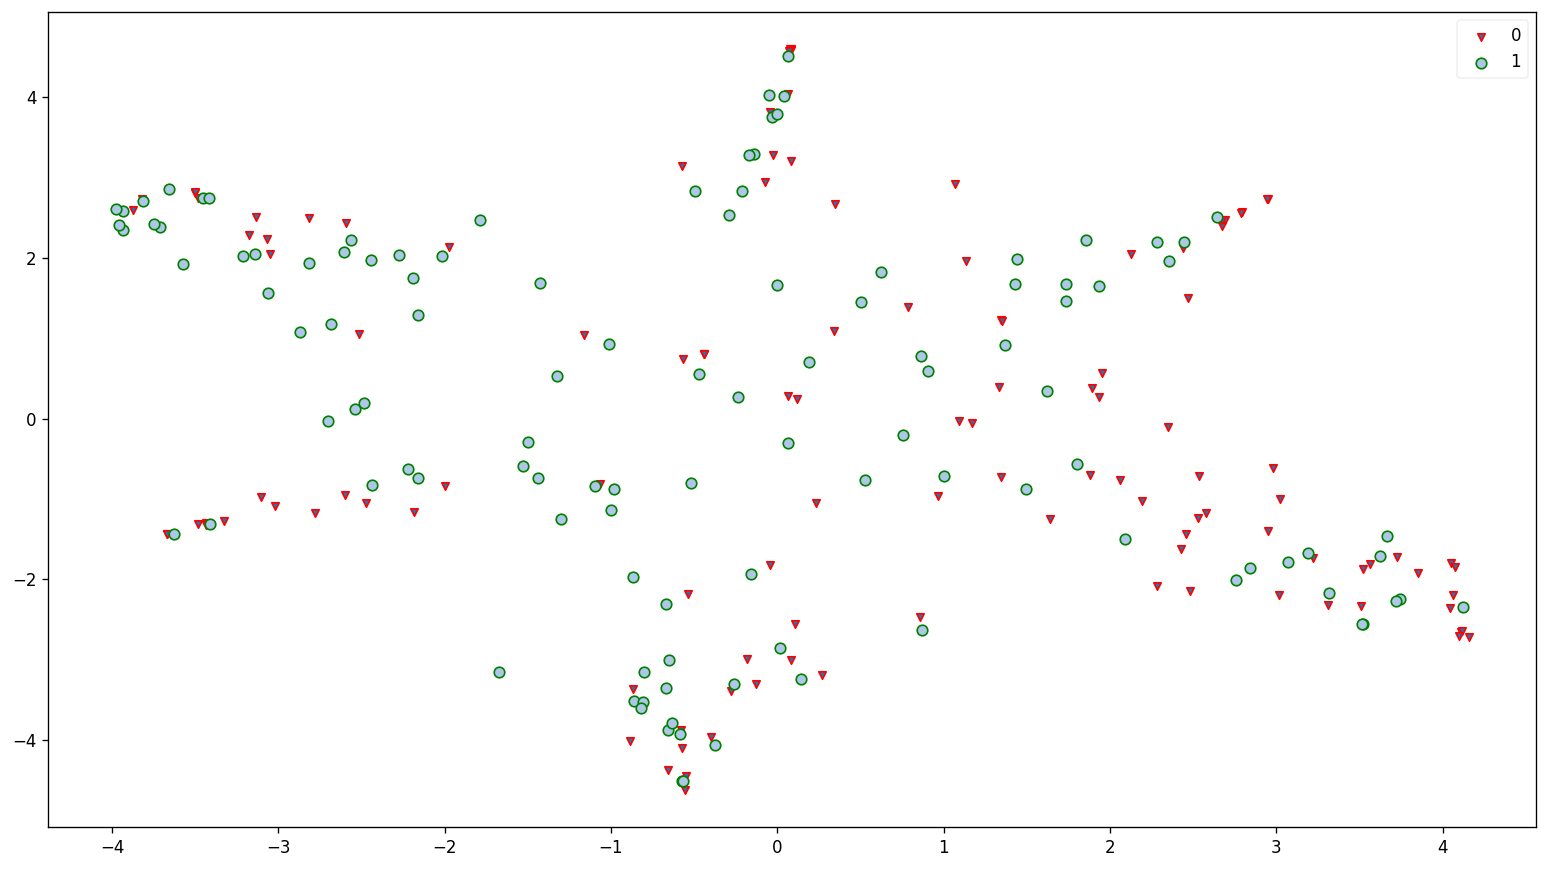

In [0]:
# targets # fake-1, real-0
import torch
targets=torch.zeros([BF.shape[0]])
for i in range(numFake):
  targets[i]=1
# targets class
target_names = ['0','1']

plot(Y)  # distribution over the topics for each document (output of LDA)

## 2. Model Design

In [0]:
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

### 2.1. Final Model

In [0]:
class GRU_model(nn.Module):
  def __init__(self):
    super(GRU_model, self).__init__()
    #You need to use "bias=False" when you define Linear functions
    self.gru = nn.GRU(emb_size, hidden,batch_first =True, num_layers=1,bidirectional=True)
    self.dropout = nn.Dropout(0.5)
    self.gru2 = nn.GRU(hidden*2, hidden,batch_first =True, num_layers=1,bidirectional=True)
    self.gru3 = nn.GRU(hidden*4, hidden,batch_first =True, num_layers=1,bidirectional=True)
    self.relu = nn.LeakyReLU(negative_slope=0.01,inplace=True)
    self.hidden= nn.Linear(d2v_size, hidden)
    self.attention = Attention(hidden*2)
    self.hidden_dim=hidden
    if emb_type==3:
      self.out  = nn.Linear(hidden*2+hidden, num_classes)
    elif emb_type in [1,3]:
      self.out  = nn.Linear(hidden, num_classes)
    else:
      self.out  = nn.Linear(hidden*2, num_classes)

  def forward(self, input,d2v): 
    if emb_type in [0,3]:
      lstm_out1, h_n=self.gru(input)
      lstm_out1=self.dropout(lstm_out1)
      lstm_out2, h_n=self.gru2(lstm_out1)
      attention_out, attn=self.attention(lstm_out2,lstm_out1)

      x=attention_out.view(input.shape[0],input.shape[1], self.hidden_dim*4)
      
      lstm_out3, h_n=self.gru3(x)
      x=torch.cat((h_n[0,:,:],h_n[1,:,:]),-1)
    else:
      x=d2v
      x=self.hidden(x)
    if emb_type==3:
      x2 =self.hidden(d2v)
      x = torch.cat((x,x2),1)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.out(x)
    x = F.log_softmax(x,dim=-1)
    return lstm_out3,x,attn

### 2.2. Attention score

In [0]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden = hidden_dim
        self.linear_in = nn.Linear(self.hidden, self.hidden, bias=False)
        self.linear_out = nn.Linear(self.hidden*2, self.hidden*2)
        
    def forward(self, output, context):
        # output: batch_size, output_len, hidden_size
        # context: batch_size, context_len, 2*hidden_size
        batch_size = output.shape[0]
        output_len = output.shape[1]
        input_len = context.size(1)
        context_in = self.linear_in(context.reshape(batch_size*input_len, -1)).view(                
            batch_size, input_len, -1) # batch_size, context_len, hidden_size   
        # context_in.transpose(1,2): batch_size, hidden_size, context_len 
        # output: batch_size, output_len, hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2)) 
        # batch_size, output_len, context_len
        attn = F.softmax(attn, dim=2) 
        # batch_size, output_len, context_len
        context = torch.bmm(attn, context)
        # batch_size, output_len, hidden_size

        output = torch.cat((context, output), dim=2) # batch_size, output_len, hidden_size*2
        output = output.view(batch_size*output_len, -1)
        output = self.linear_out(output)
        output = output.view(batch_size, output_len, -1)
        
        return output, attn

### 2.3. Dataloader

In [0]:
class Embeddings(torch.utils.data.Dataset):
  def __init__(self,lemm_train,d2v,word_sequence,word_list,word2ind,embedding,labels,maxlen):
    super(Embeddings,self).__init__()
    self.word_sequence=word_sequence
    self.word_list=word_list
    self.word2ind=word2ind
    self.embedding=torch.Tensor(embedding)
    self.labels=labels
    self.maxlen=max([len(i)for i in lemm_train])
    self.encoded=torch.zeros([len(lemm_train),maxlen,emb_size])
    self.d2v=d2v
    # Encode each sentence
    for i in range(len(lemm_train)):
      for j in range(len(lemm_train[i])):
        if j==maxlen:
          break
        self.encoded[i,j]=self.embedding[word2ind[lemm_train[i][j]]]
    print(self.encoded.shape[0])

  def __getitem__(self,index):
    # Return document encoding
    input_torch=self.encoded[index]
    label=self.labels[index]
    docvec=torch.Tensor(self.d2v[index])
    return input_torch,docvec,label

  def __len__(self):
    return self.encoded.shape[0]

In [0]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from operator import itemgetter 

# Initualize target
labels=torch.zeros([BF.shape[0]])
for i in range(numFake):
  labels[i]=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initualize hyper parameters
maxlen=1200
emb_size=embedding.shape[1]
learning_rate = 0.0005
batch_size = 16
num_classes = 2
hidden= 64
sample_size=list(range(len(lemm_train)))
train_ind, test_ind, y_train, y_test = train_test_split(sample_size, labels, test_size=0.2, random_state=42)

# Get training and testing dataset
train_text=list(itemgetter(*train_ind)(lemm_train))
test_text=list(itemgetter(*test_ind)(lemm_train))

In [0]:
# Create dataset and data loader
train_samples=Embeddings(train_text,train_d2v,word_sequence,word_list,word2ind,embedding,y_train,maxlen)
test_samples=Embeddings(test_text,test_d2v,word_sequence,word_list,word2ind,embedding,y_test,maxlen)

train_loader=DataLoader(train_samples, batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_samples, batch_size=len(y_test))

186
47


## 3. Training

In [0]:
import time
import copy
from sklearn.metrics import f1_score
net = GRU_model().to(device)
net.apply(weights_init)
optimiser = optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Collect loss and accuracy for plot
train_acces = []
test_acces = []
train_losses = []
test_losses = []

start=time.time()
lowest_loss=10
highest_accuracy=0.0
# Get validation dataset 
for input_torches,docvector,target_torches in test_loader:
  input_test,dv_test,target_test=input_torches.to(device),docvector.to(device),target_torches.long().to(device)

# Start training
for epoch in range(30):
  batch_number=1
  for input_torches,docvector,target_torches in train_loader:
    input_torches,input_dv,target_torches=input_torches.to(device),docvector.to(device),target_torches.long().to(device)
    net.train()
    _,outputs,_ = net(input_torches,input_dv) 
    loss = criterion(outputs, target_torches)
    loss.backward() 
    optimiser.step()
    optimiser.zero_grad()
    end=time.time()

    net.eval()
    _,outputs,_ = net(input_torches,input_dv) 
    loss = criterion(outputs, target_torches)
    _, predicted = torch.max(outputs, 1)
    train_acc = accuracy_score(predicted.cpu().numpy(),target_torches.cpu().numpy())
    train_acces.append(train_acc)

    _,outputs2,_ = net(input_test,dv_test)
    loss2 = criterion(outputs2, target_test)
    _, predicted = torch.max(outputs2, 1)
    test_acc = accuracy_score(predicted.cpu().numpy(),target_test.cpu().numpy())
    test_acces.append(test_acc)

    if loss2.item()<lowest_loss:
      lowest_loss=loss2.item()
      save_model_loss= copy.deepcopy(net)
    if test_acc>highest_accuracy:
      highest_accuracy=test_acc
      save_model_acc= copy.deepcopy(net)

    train_losses.append(loss.item())
    test_losses.append(loss2.item())
    print('Epoch: %d,Batch: %d, train_loss: %.5f, train_acc: %.3f, test_loss: %.5f, test_acc: %.3f' %(epoch+1 ,batch_number , loss.item(), train_acc, loss2.item(), test_acc))
    batch_number += 1
stop = time.time()
print('Runtime: ', stop - start)  

Epoch: 1,Batch: 1, train_loss: 0.67775, train_acc: 0.625, test_loss: 0.70543, test_acc: 0.447
Epoch: 1,Batch: 2, train_loss: 0.69256, train_acc: 0.438, test_loss: 0.70280, test_acc: 0.468
Epoch: 1,Batch: 3, train_loss: 0.68149, train_acc: 0.625, test_loss: 0.70314, test_acc: 0.447
Epoch: 1,Batch: 4, train_loss: 0.69626, train_acc: 0.375, test_loss: 0.70065, test_acc: 0.468
Epoch: 1,Batch: 5, train_loss: 0.69103, train_acc: 0.562, test_loss: 0.69817, test_acc: 0.447
Epoch: 1,Batch: 6, train_loss: 0.66225, train_acc: 0.750, test_loss: 0.69809, test_acc: 0.447
Epoch: 1,Batch: 7, train_loss: 0.69392, train_acc: 0.562, test_loss: 0.69693, test_acc: 0.447
Epoch: 1,Batch: 8, train_loss: 0.69576, train_acc: 0.562, test_loss: 0.69528, test_acc: 0.447
Epoch: 1,Batch: 9, train_loss: 0.69653, train_acc: 0.500, test_loss: 0.69171, test_acc: 0.553
Epoch: 1,Batch: 10, train_loss: 0.67479, train_acc: 0.750, test_loss: 0.68830, test_acc: 0.596
Epoch: 1,Batch: 11, train_loss: 0.68374, train_acc: 0.688, 

## 4. Evaluation

In [0]:
save_model_acc.gru.flatten_parameters()
for i in range(1):
  for input_torches,docvector,target_torches in test_loader:
    lstmout,outputs,attout = save_model_acc(input_torches.to(device),docvector.to(device))
    _, predicted = torch.max(outputs, 1)

    from sklearn.metrics import classification_report
    print(classification_report(target_torches,predicted.cpu().numpy(),digits=3))

              precision    recall  f1-score   support

         0.0      0.957     0.846     0.898        26
         1.0      0.833     0.952     0.889        21

    accuracy                          0.894        47
   macro avg      0.895     0.899     0.893        47
weighted avg      0.901     0.894     0.894        47



/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


In [0]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

# Imports for visualisations
from IPython.display import HTML as html_print
from IPython.display import display
import keras.backend as K
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
def get_clr(value):
  colors=['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8','#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8','#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f','#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
  value = int((value * 100) / 5)
  return colors[value]

# sigmoid function
def sigmoid(x):
	z = 1/(1 + np.exp(-x)) 
	return z


def visualize(output_values, result_list, cell_no):
	print("\nCell Number:", cell_no, "\n")
	text_colours = []
	for i in range(len(result_list)):
		text = (result_list[i], get_clr(output_values[i][cell_no]))
		text_colours.append(text)
	print_color(text_colours)

Using TensorFlow backend.


#### 4.1 Attention Visualization

In [0]:
d = 13
corps=test_text[d]
imp=attout.cpu()[d].detach().numpy()
importance=sigmoid(imp*2000)
print(visualize(importance,corps,11))
print(y_test[d])
print(predicted[d])


Cell Number: 11 



None
tensor(1.)
tensor(1, device='cuda:0')


In [0]:
y_test[3]

tensor(1.)

#### 4.2 Bi-GRU Visualization

In [0]:

corps=test_text[3]
imp=lstmout.cpu()[3].detach().numpy()
importance=sigmoid(imp)

for i in [10,50,108,105]:
  print(visualize(importance,corps,i))



Cell Number: 10 



None

Cell Number: 50 



None

Cell Number: 108 



None

Cell Number: 105 



None


#### 4.3 Result Plot

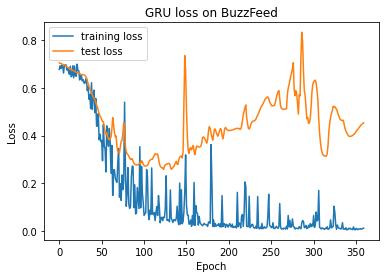

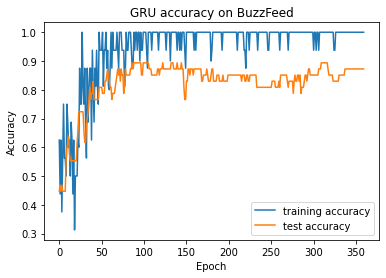

In [0]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('GRU loss on BuzzFeed')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'test loss'], loc = 'upper left')
plt.show()

# summarize history for accuracy
plt.plot(train_acces)
plt.plot(test_acces)
plt.title('GRU accuracy on BuzzFeed')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training accuracy', 'test accuracy'], loc = 'lower right')
plt.show()